In [22]:
import pandas as pd
import numpy as np
import os

DATANAME = 'MiddlePhalanxTW'
eps_list = [0.005*i for i in range(1,21)]
eps_name = f" ({eps_list[0]} to {eps_list[-1]})" 
dataset_name = DATANAME
result_file = os.path.join("kfold_kNN_data", "saved_results","Results on " + dataset_name + eps_name + '_new_' + '.csv')
df = pd.read_csv(result_file)

In [23]:
min_records = {'eTiOT': [], 'eTAOT' : []}
eps_records = {'eTiOT': [], 'eTAOT' : []}

def extract_best_eps(indices, alg):
    min_err = np.inf
    min_eps = 0
    for i in indices:
        if float(df[alg][i]) <= min_err and df['eps'][i] != 'Final error':
            min_err = float(df[alg][i])
            min_eps = float(df['eps'][i])
    return min_eps

eps_records['eTiOT'].append(extract_best_eps(range(len(df)), 'eTiOT'))
eps_records['eTAOT'].append(extract_best_eps(range(len(df)), 'eTAOT'))
eps_records['eTiOT'].append(extract_best_eps(range(1,len(df),2), 'eTiOT'))
eps_records['eTAOT'].append(extract_best_eps(range(1,len(df),2), 'eTAOT'))


In [24]:
eps_list = [0.01*i for i in range(1,11)]
eps_name = f" ({eps_list[0]} to {eps_list[-1]})"   
result_file_test = os.path.join("kNN_data", "saved_results","Results on " + dataset_name + eps_name + '_new_' +'.csv')
col_map = {"eTiOT": "eTiOT", "eTAOT": r" eTAOT($\omega = \omega_{\text{grid}})$"}
df2 = pd.read_csv(result_file_test)

In [25]:
df2.columns

Index(['eps', 'eTiOT', 'eTAOT$(\omega = \omega_{\text{grid}} \;/\; 5)$',
       'eTAOT$(\omega = \omega_{\text{grid}})$',
       'eTAOT$(\omega = \omega_{\text{grid}} \times 5)$'],
      dtype='object')

In [26]:
for i in range(len(df2)):
    if float(df2['eps'][i]) == eps_records['eTiOT'][1]:
        eps_records['eTiOT'].append(df2['eTiOT'][i])
    if float(df2['eps'][i]) == eps_records['eTAOT'][1]:
        eps_records['eTAOT'].append(df2[df2.columns[3]][i])

In [27]:
eps_records

{'eTiOT': [0.085, 0.09, np.float64(0.4675324675324676)],
 'eTAOT': [0.05, 0.05, np.float64(0.4545454545454546)]}

In [28]:
new_rows = []

# eps for final_error (grid=0.005)
new_rows.append({
    "eps": "eps_final_error",
    "eTiOT": eps_records["eTiOT"][0],
    "eTAOT": eps_records["eTAOT"][0]
})

# final_error for grid=0.01
new_rows.append({
    "eps": "eps_final_error_grid001",
    "eTiOT": eps_records["eTiOT"][1],
    "eTAOT": eps_records["eTAOT"][1],
})

# eps for grid=0.01
new_rows.append({
    "eps": "final_error_grid001",
    "eTiOT": eps_records["eTiOT"][2],
    "eTAOT": eps_records["eTAOT"][2],
})

# append new rows after the last row
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# save back
df.to_csv(result_file, index=False)
print("Updated result_file with final_error + eps values.")

Updated result_file with final_error + eps values.


In [2]:
print(len(X1[0]))

176


## Concatenate TiOT into overall results

In [5]:
import pandas as pd
import numpy as np
import os
eps_list = [0.01*i for i in range(1,11)]
eps_name = f" ({eps_list[0]} to {eps_list[-1]})" 
dataset_name = "ProximalPhalanxTW"
result_file = os.path.join("kNN_data", "saved_results","Results on " + dataset_name + eps_name + '_new_' +'.csv')
TiOT_file = os.path.join("kNN_data", "saved_results","Results on " + dataset_name + eps_name + '_freq5_TiOTonly' + '.csv')
final_file = os.path.join("kNN_data", "saved_results","Results on " + dataset_name + eps_name + '_freq5_' + '.csv')
# Read both CSV files
allresult = pd.read_csv(result_file)
TiOTresult = pd.read_csv(TiOT_file)

# Replace TiOT column in file1 with TiOT column from file2
allresult["eTiOT"] = TiOTresult["eTiOT"]

# Save the modified file1
allresult.to_csv(final_file, index=False)

## End of concatenation

## Runtime testing

In [3]:
import numpy as np
import numpy as np
import ot
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import TiOT_lib
import os



In [78]:
def gaussian_mixture_timeseries(length, n_components=3, weights=None, means=None, stds=None, random_state=None):
    """
    Generate a Gaussian mixture time series.
    
    Parameters:
        length (int): Length of the time series.
        n_components (int): Number of Gaussian components.
        weights (list or None): Mixing weights (must sum to 1). If None, uniform weights are used.
        means (list or None): Means of Gaussians. If None, random values are used.
        stds (list or None): Standard deviations of Gaussians. If None, random values are used.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        ts (ndarray): Generated time series of shape (length,).
        component_ids (ndarray): The component index chosen at each time step.
    """
    rng = np.random.default_rng(random_state)

    # Default weights
    if weights is None:
        weights = np.ones(n_components) / n_components
    weights = np.array(weights) / np.sum(weights)  # normalize
    
    # Default means and stds
    if means is None:
        means = rng.uniform(-5, 5, size=n_components)
    if stds is None:
        stds = rng.uniform(0.5, 2.0, size=n_components)

    # Sample component for each time step
    component_ids = rng.choice(n_components, size=length, p=weights)
    
    # Draw samples from corresponding Gaussians
    ts = rng.normal(means[component_ids], stds[component_ids])
    
    return ts, component_ids


# Example usage
ts, comps = gaussian_mixture_timeseries(1000, n_components=2, random_state=42)
ts2, comps = gaussian_mixture_timeseries(1000, n_components=2, random_state=41)






In [79]:
d0, pi, w, t = TiOT_lib.eTiOT(ts, ts2, eps = 0.1, freq =20, solver='newton', verbose=2, timing=True)
d0, t

Newton Algorithm converges after 4 iterations with w = 0.5592462322821663, df = -4.758041135838765e-11, df2 = 0.46436227621245096 and possible stepsize 1/df2 = 2.1534910375503644
Newton Algorithm converges after 4 iterations with w = 0.6553747481686277, df = 8.114319917075724e-10, df2 = 0.7131358392090573 and possible stepsize 1/df2 = 1.4022573891519814
Newton Algorithm converges after 4 iterations with w = 0.6939102426554288, df = -6.976653640650837e-11, df2 = 0.9449571638556749 and possible stepsize 1/df2 = 1.0582490278392471
Newton Algorithm converges after 4 iterations with w = 0.7107112382891668, df = -2.6493409788046207e-13, df2 = 1.0856189974094734 and possible stepsize 1/df2 = 0.9211334753594224
Newton Algorithm converges after 3 iterations with w = 0.7183362411873101, df = -2.287626797462471e-08, df2 = 1.1607714912455418 and possible stepsize 1/df2 = 0.8614960029100738
Newton Algorithm converges after 3 iterations with w = 0.7218601866920067, df = -1.0486843959943253e-09, df2 

(0.1650737563286158, 0.5777854999996634)

In [80]:
d1, pi, w, t = TiOT_lib.eTiOT(ts, ts2, eps = 0.1, freq = 10,  verbose=2, timing=True, eta=1.5, init_stepsize=False, subprob_tol=0.01)
d1, t

TiOT-BCD Algorithm converges after 51 iterations 


(0.1646640718816209, 0.3751735000005283)

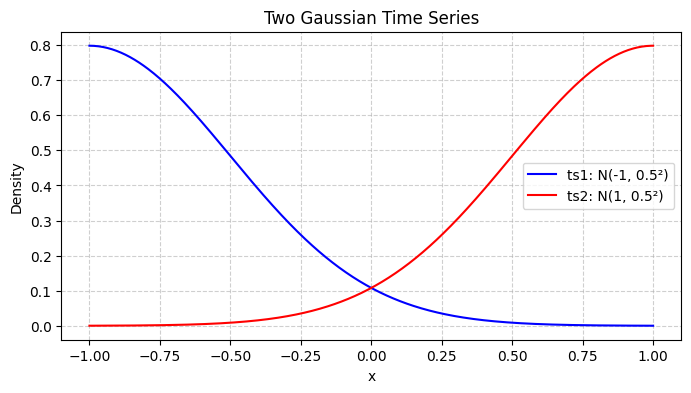

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
size = 500
np.random.seed(42)
x = np.linspace(-1, 1, size)

ts1 = norm.pdf(x, -1, 0.5)  # Gaussian centered at -1, σ=0.5
ts2 = norm.pdf(x,  1, 0.5)  # Gaussian centered at +1, σ=0.5
plt.figure(figsize=(8, 4))
plt.plot(x, ts1, label="ts1: N(-1, 0.5²)", color="blue")
plt.plot(x, ts2, label="ts2: N(1, 0.5²)", color="red")
plt.title("Two Gaussian Time Series")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [1]:
import numpy as np
def f(arr):
    arr = np.zeros(10)

a = np.ones(10)
f(a)
print(a)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [81]:
d1, pi, t = TiOT_lib.TAOT(ts, ts2, timing=True)
d1, t

(0.059083053085085074, 0.11140479999994568)

In [82]:
d1, pi, t = TiOT_lib.eTAOT(ts, ts2, eps = 0.1, freq = 10,  verbose=2, timing=True)
d1, t

TAOT-BCD Algorithm converges after 21 iterations


(0.14667939406593908, 0.02140659999986383)

In [1]:
import numpy as np
import ot
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import TiOT_lib
import os

def process_data(dataset_name, start1, start2, numpoint ):
    filepath = os.path.join("time_series_kNN", dataset_name, dataset_name + "_TRAIN.txt" )

    with open(filepath, "r") as file:
        data = [line.strip().split() for line in file]

    # Convert to numerical values if needed
    data = [[float(value) for value in row] for row in data]

    X = [row[1:] for row in data]
    X1 = X[start1: start1 + numpoint]
    X2 = X[start2: start2 + numpoint]
    return X1, X2
dataset_name = 'DistalPhalanxOutlineCorrect' 
X1, X2 = process_data(dataset_name, start1=0, start2=10, numpoint=10)


In [2]:
X, Y = X1[0], X1[6]

In [3]:
d0, pi, w, t = TiOT_lib.eTiOT(X, Y, eps = 0.01, freq = 20, solver='newton', verbose=2, timing=True)
d0, t

Newton Algorithm converges after 5 iterations with w = 0.6719733848655998, df = 9.008173547375709e-12, df2 = 0.049851568976736205 and possible stepsize 1/df2 = 20.059549188244432
Newton Algorithm converges after 4 iterations with w = 0.6873852061578691, df = 1.9319687698596266e-09, df2 = 0.4969467188430948 and possible stepsize 1/df2 = 2.0122881630610756
Newton Algorithm converges after 4 iterations with w = 0.6924423883834997, df = 1.912786986094095e-12, df2 = 0.607873572398639 and possible stepsize 1/df2 = 1.6450789200360356
Newton Algorithm converges after 3 iterations with w = 0.6911633751548044, df = 3.753581183287696e-09, df2 = 0.7421197328643944 and possible stepsize 1/df2 = 1.3474914568573093
Newton Algorithm converges after 4 iterations with w = 0.6877544285151709, df = 1.2925520029294368e-12, df2 = 0.8369982792044617 and possible stepsize 1/df2 = 1.1947455865147847
Newton Algorithm converges after 4 iterations with w = 0.6842493144112045, df = 2.473959622231736e-12, df2 = 0.8

(0.034144563942107575, 0.010279799999999284)

In [4]:
d1, pi, w, t = TiOT_lib.eTiOT(X, Y, eps = 0.01, eta=0.1, freq = 20, verbose=False, timing=True, submax_iter=100)
d1, t

(0.034146006072333125, 0.08259199999999822)

In [4]:
d2, pi, w, t = TiOT_lib.eTiOT(X, Y, eps = 0.1, freq = 20, verbose=True, timing=True, submax_iter=20)
d2, t

Total subiteration needed for PGD: 19 with df = -0.0480113146621186
Total subiteration needed for PGD: 19 with df = -0.04885730901578723
Total subiteration needed for PGD: 19 with df = -0.04720987836665548
Total subiteration needed for PGD: 19 with df = -0.04519027360131247
Total subiteration needed for PGD: 19 with df = -0.043055287024125755
Total subiteration needed for PGD: 19 with df = -0.04093485593669537
TiOT-BCD Algorithm converges after 101 iterations
||g-g_old|| = 0.0062967749262412545


(0.06279226372256227, 0.05121640000000127)

In [5]:
d3, pi, w, t = TiOT_lib.eTiOT(X, Y, eps = 0.05, freq = 4, solver='PGD', verbose=True, timing=True)
d3,t

Total subiteration needed for PGD: 49 with df = -0.028703110824373747
Total subiteration needed for PGD: 49 with df = -0.028788357247891097
Total subiteration needed for PGD: 49 with df = -0.028034624328462727
Total subiteration needed for PGD: 49 with df = -0.02712501912648551
Total subiteration needed for PGD: 49 with df = -0.026154621599509317
Total subiteration needed for PGD: 49 with df = -0.02516016023047627
Total subiteration needed for PGD: 49 with df = -0.0241575637782391
Total subiteration needed for PGD: 49 with df = -0.023153598924250215
Total subiteration needed for PGD: 49 with df = -0.02215067164831322
Total subiteration needed for PGD: 49 with df = -0.02114907998204344
Total subiteration needed for PGD: 49 with df = -0.020148124279724233
Total subiteration needed for PGD: 49 with df = -0.01914667124920419
Total subiteration needed for PGD: 49 with df = -0.01814345736337799
Total subiteration needed for PGD: 49 with df = -0.017137277407998065
Total subiteration needed fo

(0.03672474723124107, 0.5282674000000043)

In [30]:
np.abs(d1 -d0), np.abs(d2-d0), np.abs(d3-d0)

(8.512607840849284e-10, 7.136090306093801e-06, 2.9745295493516233e-06)

In [34]:
def f(x):
    return x*10, x*100
f(10)[-1]

1000

In [35]:
f(20)[-1]

2000